In [2]:
#.提取观测数据和验证双星数据
import h5py
import numpy as np
file_path=r"C:\Users\86130\Desktop\LDC2_sangria_training_v2.h5"
def extract_obs_data(file_path):
    obs_data={}
    with h5py.File(file_path,'r') as f:
        obs_tdi=f['obs/tdi'][:]
        if obs_tdi.ndim == 2 and obs_tdi.shape[1] == 1:
            obs_tdi=obs_tdi.flatten()
        obs_data['obs_time']=obs_tdi['t']
        obs_data['obs_X']=obs_tdi['X']
        obs_data['obs_Y']=obs_tdi['Y']
        obs_data['obs_Z']=obs_tdi['Z']
        obs_data['obs_A']=(obs_tdi['Z']-obs_tdi['X'])/np.sqrt(2)
        obs_data['obs_E']=(obs_tdi['X']-2*obs_tdi['Y']+obs_tdi['Z'])/np.sqrt(6)
        obs_data['obs_dt']=obs_tdi['t'][1]-obs_tdi['t'][0]
        N=len(obs_data['obs_time'])
        obs_data['obs_frequency']=np.fft.fftfreq(N,obs_data['obs_dt'])
        obs_data['obs_df']=obs_data['obs_frequency'][1]-obs_data['obs_frequency'][0]
        obs_data['obs_X_f']=np.fft.fft(obs_data['obs_X'])
        obs_data['obs_Y_f']=np.fft.fft(obs_data['obs_Y'])
        obs_data['obs_Z_f']=np.fft.fft(obs_data['obs_Z'])
        obs_data['obs_A_f']=np.fft.fft(obs_data['obs_A'])
        obs_data['obs_E_f']=np.fft.fft(obs_data['obs_E'])
        print(len(obs_data['obs_time']))
    return obs_data

obs_data=extract_obs_data(file_path)
def extract_vgb_data(file_path):
    vgb_data={}
    with h5py.File(file_path,'r') as f:
        vgb_tdi=f['sky/vgb/tdi'][:]
        if vgb_tdi.ndim == 2 and vgb_tdi.shape[1] == 1:
            vgb_tdi=vgb_tdi.flatten()
        vgb_data['vgb_t']=vgb_tdi['t']
        vgb_data['vgb_X']=vgb_tdi['X']
        vgb_data['vgb_Y']=vgb_tdi['Y']
        vgb_data['vgb_Z']=vgb_tdi['Z']
        vgb_data['vgb_A']=(vgb_tdi['Z']-vgb_tdi['X'])/np.sqrt(2)
        vgb_data['vgb_E']=(vgb_tdi['X']-2*vgb_tdi['Y']+vgb_tdi['Z'])/np.sqrt(6)
        vgb_data['vgb_X_f']=np.fft.fft(vgb_data['vgb_X'])
        vgb_data['vgb_Y_f']=np.fft.fft(vgb_data['vgb_Y'])
        vgb_data['vgb_Z_f']=np.fft.fft(vgb_data['vgb_Z'])
        vgb_data['vgb_A_f']=np.fft.fft(vgb_data['vgb_A'])
        vgb_data['vgb_E_f']=np.fft.fft(vgb_data['vgb_E'])

    return vgb_data
vgb_data=extract_vgb_data(file_path)
#.提取验证双星参数
import pandas as pd
def extract_vgb_parameters(file_path):
    with h5py.File(file_path,'r') as f:
        vgb_cat=f['sky/vgb/cat'][:]
        vgb_cat_flat=vgb_cat.flatten()
        vgb_frame=pd.DataFrame(vgb_cat_flat)
        config={}
        config_group=f['sky/vgb/config']
        for key in config_group.keys():
            config[key]=config_group[key][()]
    return vgb_frame,config
vgb_frame,config=extract_vgb_parameters(file_path)
print(config)
def get_vgb_parameters(vgb_frame,binary_index=0):
    binary_data=vgb_frame.iloc[binary_index]
    binary_parameters={
        'name':binary_data['Name'],
        'amplitude':binary_data['Amplitude'],
        'frequency':binary_data['Frequency'],
        'frequency_derivative':binary_data['FrequencyDerivative'],
        'ecliptic_latitude':binary_data['EclipticLatitude'],
        'ecliptic_longitude':binary_data['EclipticLongitude'],
        'inclination':binary_data['Inclination'],
        'initial_phase':binary_data['InitialPhase'],
        'polarization':binary_data['Polarization'],
        'distance':binary_data['Distance'],
        'mass1':binary_data['Mass1'],
        'mass2':binary_data['Mass2'],
        'drift':binary_data.get('Drift',np.nan),
        'error_distance':binary_data.get('ErrorDistance',np.nan),
        'error_mass1':binary_data.get('ErrorMass1',np.nan),
        'error_mass2':binary_data.get('ErrorMass2',np.nan),
        'galactic_latitude':binary_data.get('GalacticLatitude',np.nan),
        'galactic_longitude':binary_data.get('GalacticLongitude',np.nan),
        'period':binary_data.get('Period',np.nan)
    }
    return binary_parameters

def get_all_vgb_parameters(vgb_frame):
    all_parameters=[]
    for i in range(len(vgb_frame)):
        all_parameters.append(get_vgb_parameters(vgb_frame,i))
    return all_parameters

first_binary_parameters=get_vgb_parameters(vgb_frame,binary_index=2)
all_binaries_params=get_all_vgb_parameters(vgb_frame)
all_params=pd.DataFrame(all_binaries_params)
print(first_binary_parameters)
first_binary_parameters['amplitude']
#.设置合理的参数值
import numpy as np
from scipy.stats import  uniform
import astropy.units as u
import pandas as pd
class Bayesianprior:
    relative_ranges={
            'mass1':0.3,
            'mass2':0.35,
            'distance':0.4,
            'frequency':0.1,
            'frequency_derivative':1,
            'inclination':0.2,
            'galactic_latitude':0.1,
            'galactic_longitude':0.1,
            'ecliptic_latitude':0.1,
            'ecliptic_longitude':0.1,
            'initial_phase':0.2,
            'polarization':0.2
        }
    absolute_limits={
            'mass1':(0.1,1.7),
            'mass2':(0.01,1.1),
            'distance':(50,20000),
            'frequency':(1e-5,2e-2),
            'frequency_derivative':(-1e-15,1e-15),
            'inclination':(0,np.pi/2),
            'galactic_latitude':(-np.pi/2,np.pi/2),
            'galactic_longitude':(0,2*np.pi),
            'ecliptic_latitude':(-np.pi/2,np.pi/2),
            'ecliptic_longitude':(0,2*np.pi), 
            'initial_phase':(0,2*np.pi),
            'polarization':(0,2*np.pi)
        }
    param_names=['mass1','mass2','distance','frequency','frequency_derivative','inclination','galactic_latitude','galactic_longitude','ecliptic_latitude','ecliptic_longitude','initial_phase','polarization']

    def __init__(self):
        #调用验证双星参数
        self.vgb_frame=vgb_frame
        self.num_systems=len(vgb_frame)
        
    def get_prior_bounds(self,binary_index):

        binary_params=get_vgb_parameters(self.vgb_frame,binary_index)
        bounds={}
        for param_name in self.param_names:
            param_value=binary_params[param_name]
            abs_min,abs_max=self.absolute_limits[param_name]
            relative_range=self.relative_ranges[param_name]
            low_bound=max(abs_min,param_value*(1-relative_range))
            high_bound=min(abs_max,param_value*(1+relative_range))
            bounds[param_name]={
                'low':low_bound,
                'original_value':param_value,
                'high':high_bound,
                'type':uniform,   
            }
        return bounds
    
    def log_prior(params):
        for i,param_value in enumerate(params):
            param_name=param_name[i]
            param_bounds=bounds[param_name]
            low=param_bounds['low']
            high=param_bounds['high']
            if not (low<=param_value<=high):
                return -np.inf
        return 0.0
    
Bayesianprior=Bayesianprior()
bounds=Bayesianprior.get_prior_bounds(binary_index=2)
print(bounds)
#产生一组数据验证计算
params_data={
    'mass1':bounds['mass1']['original_value'],
    'mass2':bounds['mass2']['original_value'],
    'distance':bounds['distance']['original_value'],
    'frequency':bounds['frequency']['original_value'],
    'frequency_derivative':bounds['frequency_derivative']['original_value'],
    'inclination':bounds['inclination']['original_value'],
    'ecliptic_latitude':bounds['ecliptic_latitude']['original_value'],
    'ecliptic_longitude':bounds['ecliptic_longitude']['original_value'],
    'initial_phase':bounds['initial_phase']['original_value'],
    'polarization':bounds['polarization']['original_value'],
}
print(params_data['mass1'])
print(params_data['mass2'])
print(params_data['distance'])
print(params_data['frequency'])
print(params_data['frequency_derivative'])
print(params_data['inclination'])
print(params_data['ecliptic_latitude'])
print(params_data['ecliptic_longitude'])
print(params_data['initial_phase'])
print(params_data['polarization'])

6307200
{'approximant': b'TD_fdot', 'catalogs': b'/data/Params_VGBind_210910.hdf5', 'nsource': np.int64(36), 'seed': np.int64(1234), 'source_type': b'GB'}
{'name': b'SDSSJ0923', 'amplitude': np.float64(2.638561000683058e-22), 'frequency': np.float64(0.0005149728351829441), 'frequency_derivative': np.float64(1.0507323654511276e-19), 'ecliptic_latitude': np.float64(0.25183010111081694), 'ecliptic_longitude': np.float64(2.3336860897962515), 'inclination': np.float64(1.0471975511965976), 'initial_phase': np.float64(3.339198104910743), 'polarization': np.float64(1.8768107855557548), 'distance': np.float64(299.0), 'mass1': np.float64(0.275), 'mass2': np.float64(0.76), 'drift': np.float64(0.0), 'error_distance': np.float64(10.0), 'error_mass1': np.float64(0.015), 'error_mass2': np.float64(0.23), 'galactic_latitude': np.float64(0.7814782094002161), 'galactic_longitude': np.float64(3.417702144406621), 'period': np.float64(3883.7)}
{'mass1': {'low': np.float64(0.1925), 'original_value': np.float

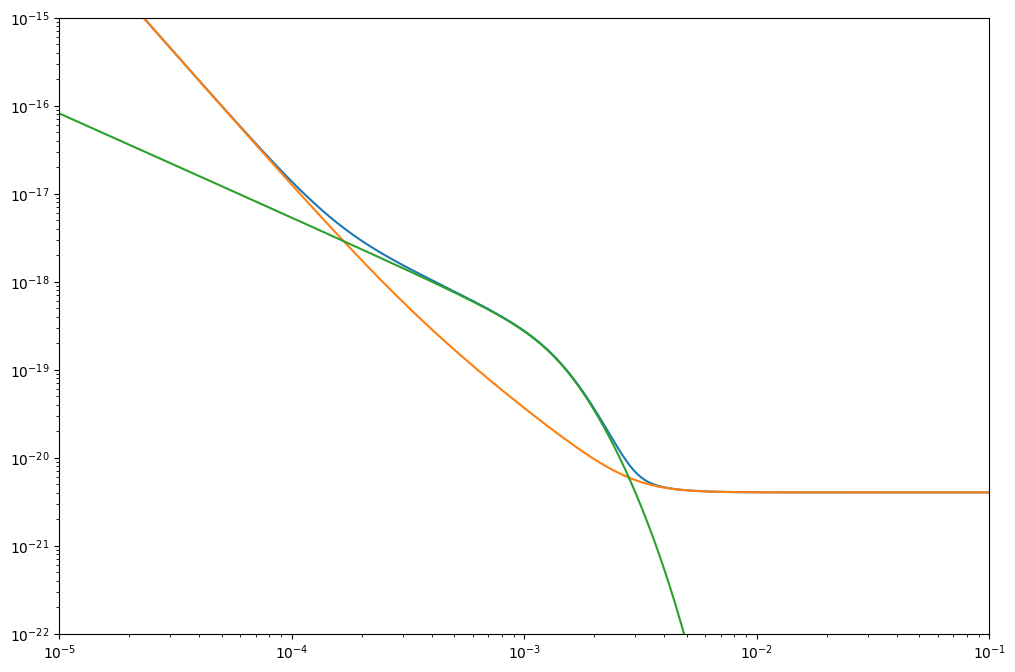

In [4]:
'''测试代码,主要针对于tdi的测试工作'''
'''严格定义Amaro-Seoane et al.(2017)的噪声模板构建'''
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c
class LisaNoiseVertification:
    def __init__(self):
        self.L_arm=2.5e9
        self.f_star=c/(2*np.pi*self.L_arm)
    def get_instrumental_psd(self,f):
        sa_sqrt=3e-15*np.sqrt(1+(0.4e-3/f)**2)*np.sqrt(1+(f/8e-3)**4)
        Sa=sa_sqrt**2
        Sx_sqrt=10e-12*np.sqrt(1+(2e-3/f)**4)
        Sx=Sx_sqrt**2
        S_n_inst=(Sx/self.L_arm**2)+(Sa/(self.L_arm**2*(2*np.pi*f)**4))
        return S_n_inst
    def get_galactic_psd(self,f):
        A=9e-45
        alpha=0.138
        beta=-2.21
        kappa=521
        gamma=1680
        f_k=0.00113
        S_c=A*f**(-7/3)*np.exp(-f**alpha+beta*f*np.sin(kappa*f))*(1+np.tanh(gamma*(f_k-f)))
        return S_c
    def get_total_psd(self,f):
        s_inst=self.get_instrumental_psd(f)
        s_gal=self.get_galactic_psd(f)
        return s_inst+s_gal
    def plot_sensitivity_curve(self):
        freqs=np.logspace(-5,-1,1000)
        s_inst=self.get_instrumental_psd(freqs)
        s_gal=self.get_galactic_psd(freqs)
        s_total=s_inst+s_gal
        plt.figure(figsize=(12,8))
        plt.loglog(freqs,np.sqrt(s_total))
        plt.loglog(freqs,np.sqrt(s_inst))
        plt.loglog(freqs,np.sqrt(s_gal))
        plt.xlim(1e-5,1e-1)
        plt.ylim(1e-22,1e-15)
        plt.show()
noise_model=LisaNoiseVertification()
noise_model.plot_sensitivity_curve()